# Testing our different gravity darkening models

Let's test some different gravity darkening models and compare them to brute force numerical integration to see which are most accurate:

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import lightkurve as lk

import plot_spheroid as ps
import sympy as sp

from ipywidgets import *
import pandas as pd
from sympy import latex
from IPython.display import display, Math

import utils
import starry
import numpy as np

starry.config.lazy = False
starry.config.quiet = True

## Spherical approximation with gravity darkening:

Here, we will assume the star is a sphere (no oblateness), but still gravity darkened. A real star would look the same but squashed on the rotation axis by a factor $\frac{1}{1-f}$.

First get the spherical harmonic coefficients (second-order approximation)

In [2]:
order_approx = 2
utils.poly_approx(order_approx=order_approx)

Matrix([
[                                                                       1],
[                                                                       0],
[                                                                       0],
[                                                                       0],
[                                          2*beta*(omega**4 - 2*omega**2)],
[                                                                       0],
[                                                                       0],
[                                                                       0],
[                                          2*beta*(omega**4 - 2*omega**2)],
[                                                                       0],
[                                                                       0],
[                                                                       0],
[                                                                       0],
[  

In [3]:
omega, beta, ycoeffs = utils.spherical_approx(order_approx=order_approx)
ycoeffs

Matrix([
[                pi*(8*beta*(2*beta - 1)*(omega**4 - 2*omega**2)**2 + 20*beta*(omega**4 - 2*omega**2) + 15)/15],
[                                                                                                            0],
[                                                                                                            0],
[                                                                                                            0],
[                                                                                                            0],
[                                                                                                            0],
[4*sqrt(5)*pi*beta*(omega**4 - 2*omega**2)*(-8*beta*(omega**4 - 2*omega**2) + 4*omega**4 - 8*omega**2 - 7)/105],
[                                                                                                            0],
[                                                                                      

In [4]:
alpha = sp.symbols('alpha')
first_term = sp.expand(ycoeffs[0]); first_term

16*pi*beta**2*omega**8/15 - 64*pi*beta**2*omega**6/15 + 64*pi*beta**2*omega**4/15 - 8*pi*beta*omega**8/15 + 32*pi*beta*omega**6/15 - 4*pi*beta*omega**4/5 - 8*pi*beta*omega**2/3 + pi

In [5]:
alpha = -2*omega**2 + omega**4
expr = sp.expand(2*sp.pi*(alpha**2*beta**2)/3 - sp.pi*(alpha**2*beta)/3 + sp.pi*(alpha*beta) + sp.pi); expr

2*pi*beta**2*omega**8/3 - 8*pi*beta**2*omega**6/3 + 8*pi*beta**2*omega**4/3 - pi*beta*omega**8/3 + 4*pi*beta*omega**6/3 - pi*beta*omega**4/3 - 2*pi*beta*omega**2 + pi

In [6]:
(expr).evalf(subs={omega:0.783244373599367,beta:0.22})

2.46035907079315

Now, let's create a (realistic, modeled on WASP-33) star with gravity darkening and limb darkening:

[ 3.04448319e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  4.38484186e-02  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -3.12859341e-04  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00]


<IPython.core.display.Javascript object>


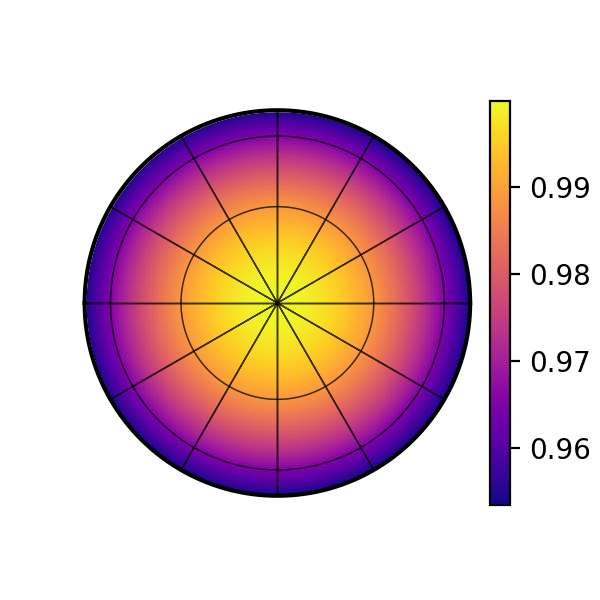

In [7]:
u1 = 0.246
u2 = 0.252
inc = 90
omega_s = 0.23#(np.sin(np.radians(90-inc))) #should create a function converting vsini to omega*sini
#omega_s = 2*pi
#omega_s = 0
map33 = starry.Map(ydeg=order_approx*2) #ydeg = 2*order_approx udeg=2

arr = []
G_mks = 6.67e-11
Msun = 1.989e+30
Rsun = 6.95700e8
M_star = 1.59
R_star = 1.561
for i in ycoeffs:
    arr.append(float(i.evalf(subs={omega:omega_s, beta:0.22}))) #use G=1, M=1, omegaa = 0.60
arr = np.array(arr)
print(arr)
map33[1:,:] = arr[1:] / arr[0]
map33.amp = arr[0]
map33.rotate(axis=[1,0,0],theta=90)

star = starry.Primary(map33, m=M_star, r=R_star,prot=100000)
star.map.inc=90-inc
#star.map[1] = 0#u1
#star.map[2] = 0#u2
star.map.show(colorbar=True)

Now, let's create a planet (also modeled on WASP-33b)

In [8]:
planet = starry.kepler.Secondary(map=starry.Map(lmax=2),
    m=0,  # mass in solar masses
    r=0.1087*star.r,  # radius in solar radii
    porb=1.2198681,  # orbital period in days
    inc=90,#88.01,
    Omega=92,  # longitude of ascending node in degrees
    ecc=0.0,  # eccentricity
    w=0,  # longitude of pericenter in degrees
    t0=0,  # time of transit in days
)

system = starry.System(star, planet)

### Creating lightcurves and comparing to real data!

In [9]:
system.flux(0.0); #hack to compile and create lightcurves faster

In [10]:
omega_s

0.23

In [11]:
time = np.linspace(planet.porb-0.15, planet.porb+0.15, 500)
flux_star, flux_planet = system.flux(time, total=False)

<IPython.core.display.Javascript object>


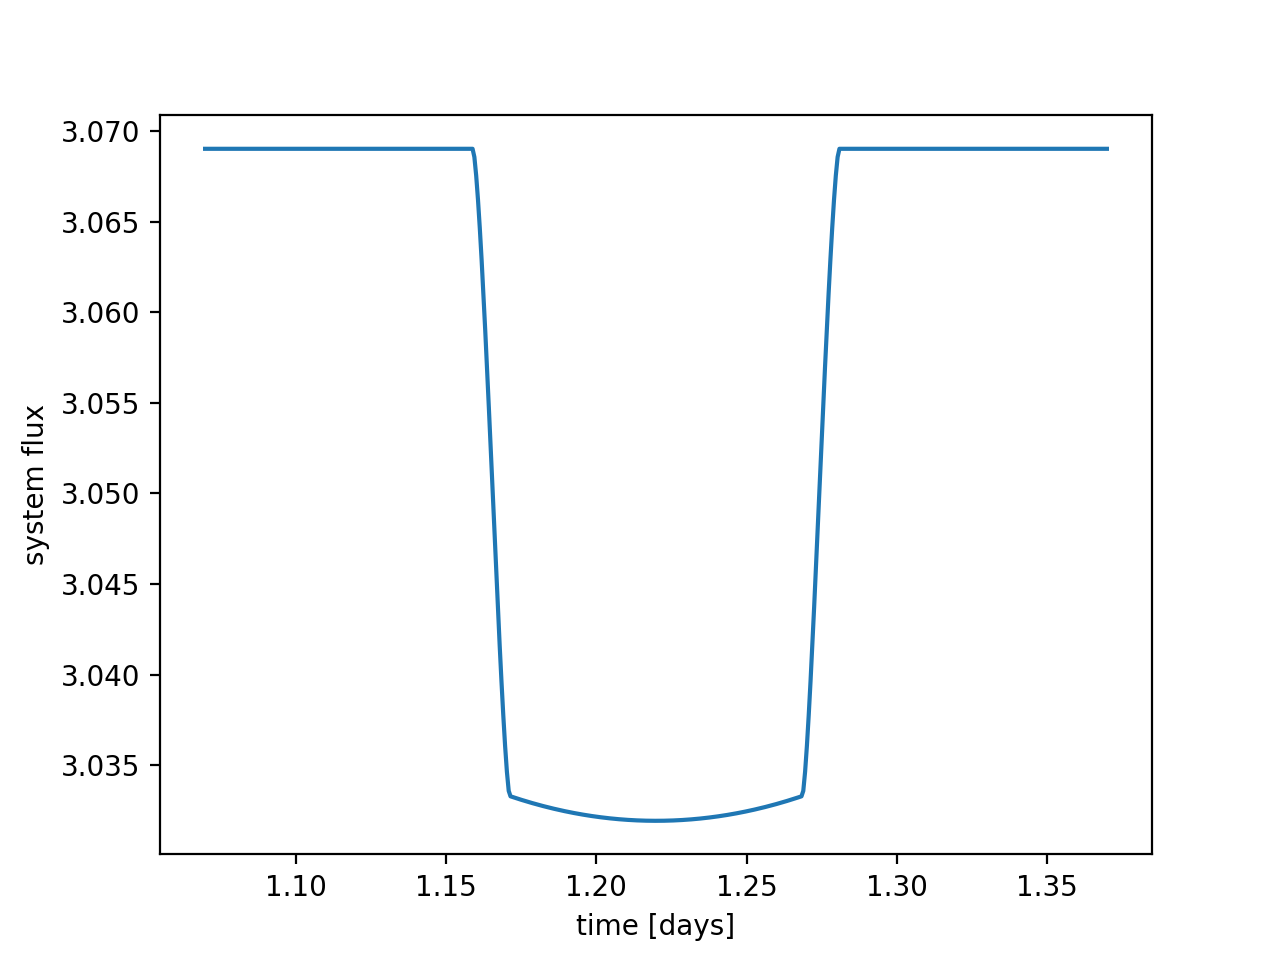

In [12]:
plt.plot(time, flux_star)
plt.xlabel("time [days]")
plt.ylabel("system flux");

<IPython.core.display.Javascript object>


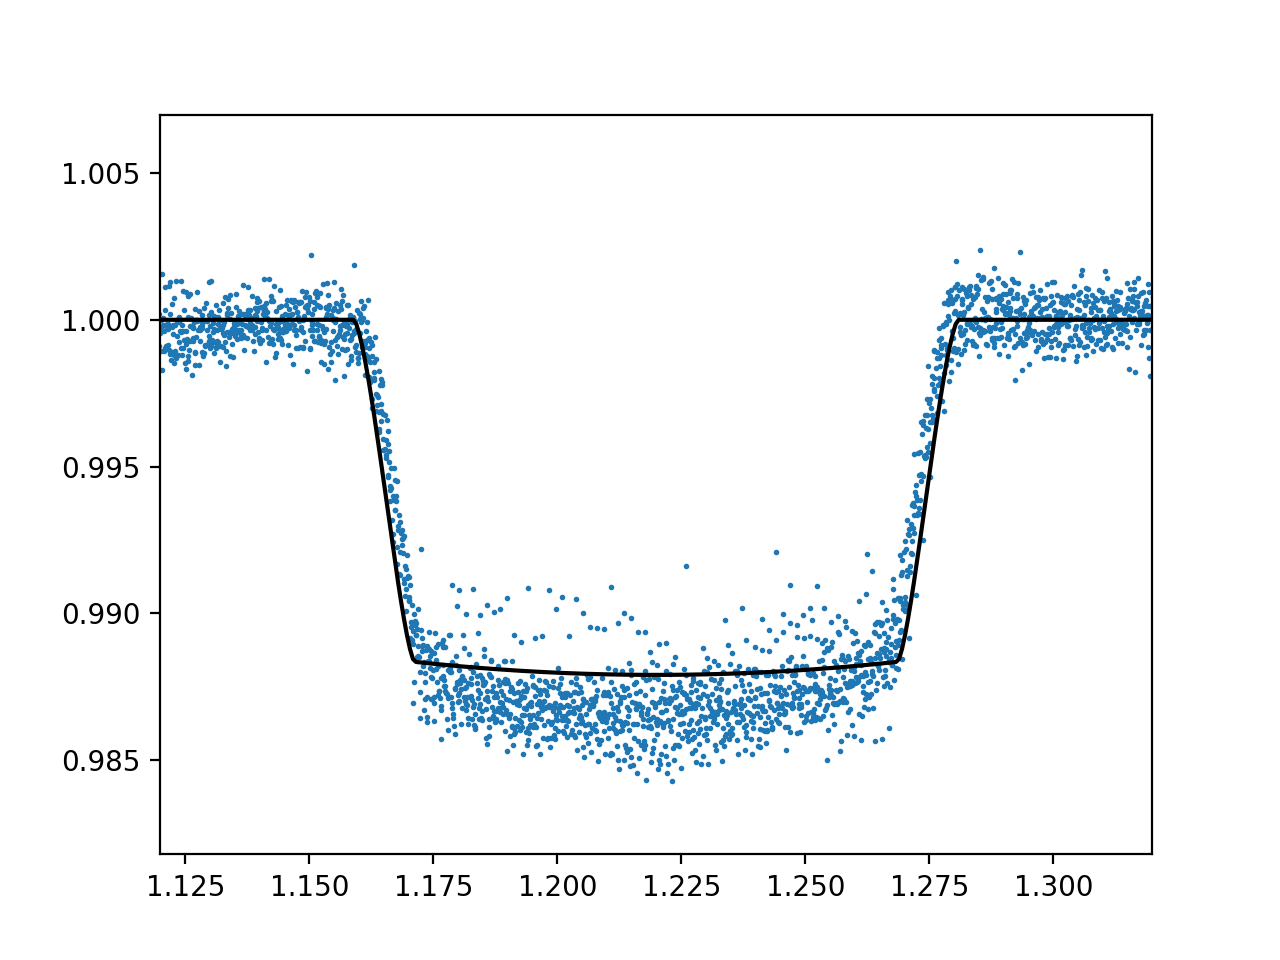

In [13]:
df = pd.read_csv("/Users/shashank/Documents/Python Files/wasp33TESS_clean.csv")
lc = lk.LightCurve(time=df.time,flux=df.flux)
wasp33_params = {'Epoch':2458792.63403-2457000, 'period':planet.porb,'tdur':0.1300}

fold = lc.fold(wasp33_params['period'],wasp33_params['Epoch'])
plt.xlim(planet.porb-0.1,planet.porb+0.1)
plt.scatter(fold.phase*wasp33_params['period']+wasp33_params['period'],fold.flux,s=1)
plt.plot(time, flux_star/flux_star[0],c='k')

In [ ]:
system.show(t=np.linspace(0, planet.porb, 50), window_pad=4, figsize=(8, 8))

In [14]:
starry.config.lazy = False
import theano.tensor as tt
import theano.sparse as ts
import theano
x, y, z = system.position(time)

In [15]:
_, xo = x
_, yo = y
_star, zo = z

In [16]:
bo = np.sqrt(xo**2+yo**2)/star.r
theta = np.arctan2(xo, yo)
f = 0.02640963225631405 #(utils.f(omega_s))
A = np.array(star.map.ops.A.eval().todense())

In [17]:
print(utils.f(omega_s))
star.map.rotate(axis=[1,0,0],theta=-90)

0.992036637681875


In [18]:
from tqdm.notebook import tqdm

tT = np.zeros(star.map.N)
for n in range(star.map.N):
    tT[n] = utils.tT_numerical(np.array([0,2*np.pi]), (1-f), theta[0], n)
tTA = np.dot(tT,A)
amp_star = np.dot(tTA, star.map.y)


terms = star.map.N
fluxes = np.zeros_like(time)
for i in tqdm(range(len(time))):
    sT = utils.semi_analytic_sT(f, theta[i], bo[i], planet.r/star.r, terms)
    sTA = np.dot(sT,A)
    #sTAR = star.map.ops.tensordotRz(sTA.reshape(1,-1), np.array([theta[i]]))
    fluxes[i] = np.dot(sTA, star.map.y)
    
flux_oblate = ((amp_star-fluxes)*star.map.amp)

<IPython.core.display.Javascript object>


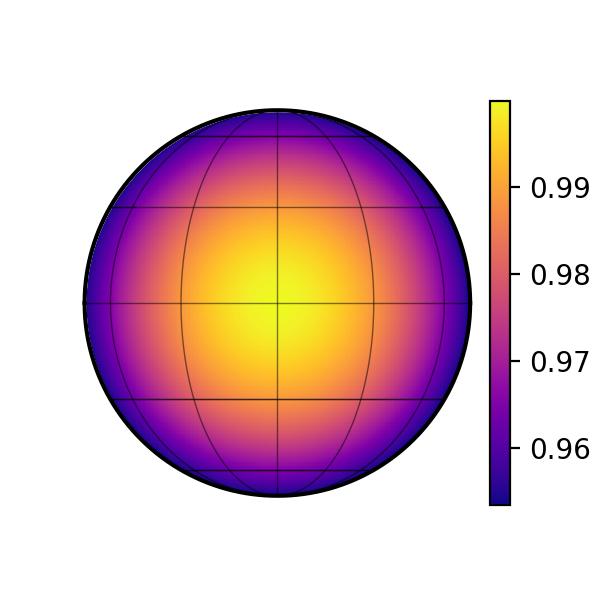

In [19]:
star.map.inc=90
star.map.show(colorbar=True)

<IPython.core.display.Javascript object>


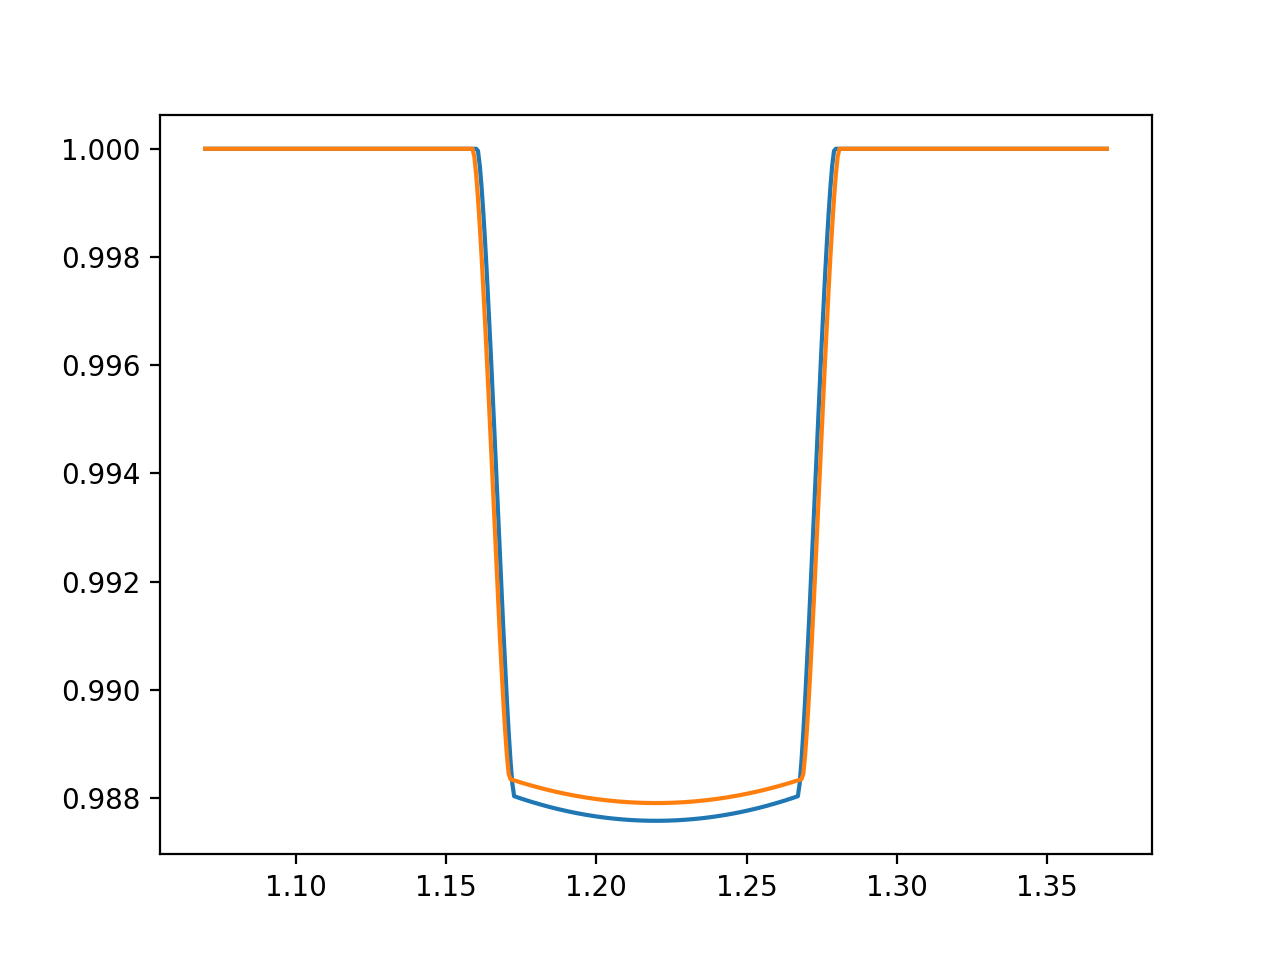

In [20]:
plt.plot(time, flux_oblate/flux_oblate[0])
plt.plot(time, flux_star/flux_star[0])

In [38]:
%load_ext autoreload
%autoreload 2
import pytransit
from pytransit import OblateStarModel, QuadraticModel
print(pytransit.__file__)
tmo = OblateStarModel(sres=1000, pres=10, rstar = 1.561)
tmc = QuadraticModel(interpolate=False)

time = np.linspace(1.2198696-0.15, 1.2198696+0.15, 500)
tmo.set_data(time)
tmc.set_data(time)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/Users/shashank/anaconda3/lib/python3.7/site-packages/PyTransit-2.4.0-py3.7.egg/pytransit/__init__.py


In [39]:
omega_s = np.abs(0.23)#/(np.sin(np.radians(90-inc))))
print(omega_s)
k = np.array([0.1087])
p_rot = (2*np.pi*(R_star*Rsun)**(3/2))/(omega_s*(G_mks*M_star*Msun)**(1/2)*(60*60*24))
#p_rot = 100.0
print(p_rot) #rotation period in days
#i = 88.01
t0, p, a, i, az, e, w = 0.0, 1.2198696, 3.614, 90*(np.pi/180), 92*(np.pi/180.), 0.0, 0.0 #real t0 is 2458792.63403
rho, rperiod, tpole, phi, beta = 0.59, p_rot,7600, (inc)*(np.pi/180.), 0.22
#rho, rperiod, tpole, phi, beta = 0.59, 100,7400, -50.0*(np.pi/180.), 0.22
ldc = np.array([0, 0]) # Quadtratic limb darkening coefficients

0.23
0.7791064124112946


<IPython.core.display.Javascript object>


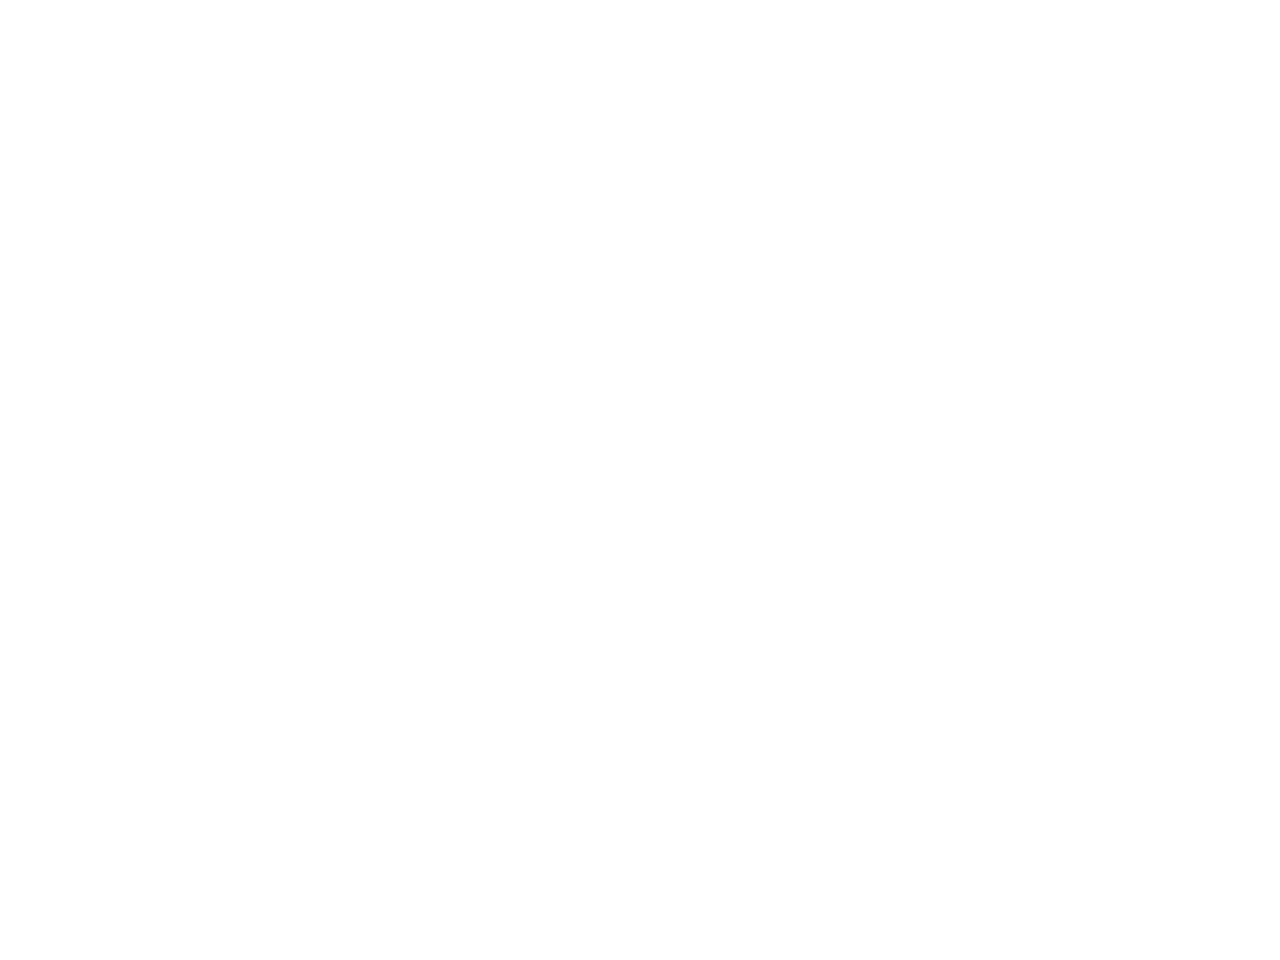

NameError: name 'flux_om' is not defined

In [23]:
%matplotlib notebook
df = pd.read_csv("/Users/shashank/Documents/Python Files/wasp33TESS_clean.csv")
lc = lk.LightCurve(time=df.time,flux=df.flux)
wasp33_params = {'Epoch':2458792.63403-2457000, 'period':1.2198696,'tdur':0.1300}

fold = lc.fold(wasp33_params['period'],wasp33_params['Epoch'])
#plt.xlim(planet.porb-0.1,planet.porb+0.1)
plt.scatter(fold.phase*wasp33_params['period']+wasp33_params['period'],fold.flux,s=1)
plt.plot(time,flux_om, lw=2, c='k')

In [ ]:
plt.plot(time, flux_star/flux_star[0],c='r')
plt.plot(time,flux_om, lw=2, c='k')
plt.plot(time,flux_oblate/flux_oblate[0], lw=2, c='b')


<IPython.core.display.Javascript object>


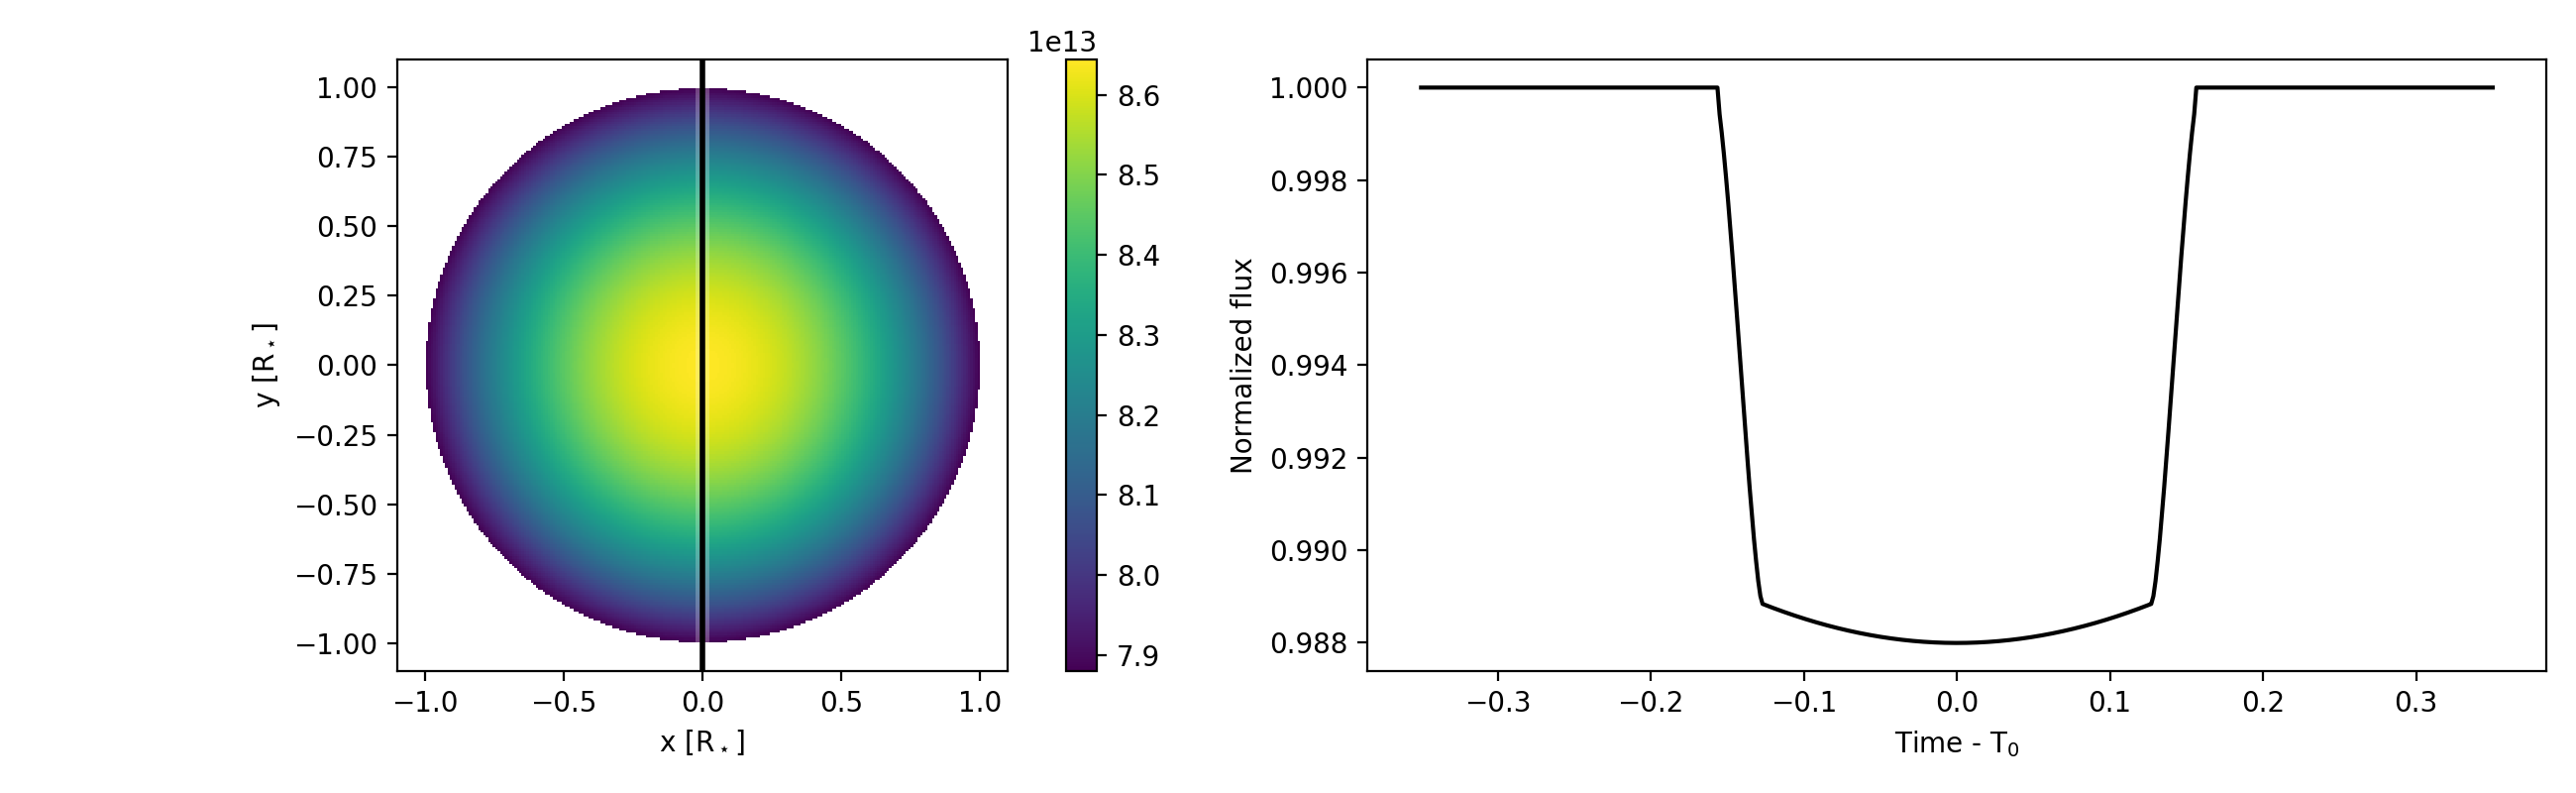

In [53]:
b = 0.00
grids = tmo.visualize(0.10714, b, 90*(np.pi/180.), rho, rperiod, tpole, phi, beta, np.array([0,0]), ires=256)

In [41]:
tmo.rstar

1085987700.0